# Models for J1257 QPO
Notebook to study characteristic frequencies of different QPO models applied to the supermassive black hole 2MASXJ12571076+2724177

Known parameters:
* $M = 10^{6.3} M_\odot$
* $\nu = 3.3 * 10^{-5}$ HZ
* $d = 90$ Mpc

let's look for a range of frequencies and masses around these parameters

### General settings

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
#let's set the parameters
M_bh = 10**6.3
nu0 = 3.3*10**(-5)

# Physical constants
G = 6.67430e-11       # m^3 kg^-1 s^-2
c = 299792458         # m/s
Msun = 1.98847e30     # kg

Rg_sun = G * Msun / c**2  # in m

In [33]:
#let's set the tolerance for the target frequency
tol = 0.01 * nu0  # 1% tolerance
target_min = 1e-5
target_max = 1e-4

### Useful functions for every model

In [34]:
# Kerr frequencies in Hz
# i compute Rg separating M because I'll may try some different value
def nu_phi(r, a, M=M_bh):
    # r in units of GM/c^2, a dimensionless (0–1), M in solar masses
    Rg = Rg_sun * M  # in cm
    return c / (Rg*(r**1.5 + abs(a)))

def nu_theta(r, a, M=M_bh):
    vphi = nu_phi(r, a, M)
    factor = np.sqrt(1 - (4*abs(a))/r**1.5 + (3*a**2)/r**2)
    return vphi * factor

def nu_r(r, a, M=M_bh):
    vphi = nu_phi(r, a, M)
    factor = np.sqrt(1 - (6)/r + (8*abs(a))/r**1.5 - (3*a**2)/r**2)
    return vphi * factor

In [35]:
# Kerr ISCO radius
def r_isco(a):
    if a==0:
        return 6
    Z1 = 1 + (1 - a**2)**(1/3) * ((1 + a)**(1/3) + (1 - a)**(1/3))
    Z2 = np.sqrt(3*a**2 + Z1**2)
    return 3 + Z2 - abs(a)/a*np.sqrt((3 - Z1)*(3 + Z1 + 2*Z2))

### FIRST MODEL - RELATIVISTIC PRECESSION

in this model the QPO frequency is generally identified with the Lense-Thirring precesion around a spinning compact object.
alternatively, also the periastreon precession frequency or the rotation frequency can be associated with it.

in any case, the frequencies will only depend on three parameters: the mass of the objecy, its spin, and distance from the central object

> OSS: the Kerr frequencies are inddependent on the sign of the spin, so prograde and retrograde spins give the same resulkts! - we'll therefore study only prograde spins

In [36]:
# lense-thirring precession frequency
def nu_LT(r, a, M=M_bh):
    return nu_phi(r, a, M) - nu_theta(r, a, M)

#periastron precession frequency
def nu_per(r, a, M=M_bh):
    return nu_phi(r, a, M) - nu_r(r, a, M)

In [37]:
#function to find the matching combinations

def find_match(a_range, r_ranges, model, Ms=M_bh):
    matches = []
    if Ms is list or isinstance(Ms, np.ndarray):
        for M in Ms:
            for i, a in enumerate(a_range):
                for r in r_ranges[i]:
                    freq = model(r, a, M)
                    if abs(freq - nu0) < tol:
                        matches.append((M, a, r, freq))
    else:
        for i, a in enumerate(a_range):
            for r in r_ranges[i]:
                freq = model(r, a)
                if abs(freq - nu0) < tol:
                    matches.append((M_bh, a, r, freq))
    return matches

def stampa(matches):
    print(f"Found {len(matches)} matches:")
    for m in matches:
        print(f"a={m[1]}, r={m[2]} R_g → ν={m[3]} Hz")

In [38]:
#functions for plots

def select(a_match, n_pick=10):
    a_match = np.array(a_match)
    # Sample a few spin values for clarity
    idx = np.linspace(0, len(a_match)-1, n_pick).astype(int)
    a_sampled = a_match[idx]
    return a_sampled

def plot_nu_vs_r(a_sampled, M, nu0, target_min, target_max, label, title, model):
    plt.figure(figsize=(9,6))

    for a in a_sampled:
        r_grid = np.linspace(r_isco(a), 1e4, 800)
        freq = np.array([model(r, a, M) for r in r_grid])
        plt.plot(r_grid, freq, label=f"a = {a:.5f}")
        
    # Target frequency band
    plt.fill_between(r_grid, target_min, target_max, color='gray', alpha=0.2,
                    label="Target range")
    plt.plot(r_grid, np.ones_like(r_grid)*nu0, label="Target frequency")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("r  [GM/c²]")
    plt.ylabel(label)
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [39]:
# set parameters range
a_range = np.linspace(0, 95, 96)  # Spins
a_range = a_range/100
a_range = np.append(a_range, 0.998)      # add extreme prograde spin

r_ranges = [np.exp(np.linspace(np.log(r_isco(a)), np.log(1e4), 800)) for a in a_range]

#the linear span semms to produce different results...
#r_ranges = [np.arange(r_isco(a), 1e4, 800) for a in a_range]     # Radii in GM/c^2

#### Let's start by considering the fixed mass given above

##### first, LT precession

In [40]:
#let's look for all the matching combinations of parameters
LT_matches = find_match(a_range, r_ranges, nu_LT)
# Print results
stampa(LT_matches)

Found 62 matches:
a=0.04, r=6.264038533505196 R_g → ν=3.272044624341112e-05 Hz
a=0.05, r=6.711271832722068 R_g → ν=3.3172585839277846e-05 Hz
a=0.06, r=7.124168120584549 R_g → ν=3.319839208620976e-05 Hz
a=0.07, r=7.4926131039570425 R_g → ν=3.321515884647207e-05 Hz
a=0.09, r=8.135117810995727 R_g → ν=3.321158542293149e-05 Hz
a=0.12, r=8.950231938702279 R_g → ν=3.303226696439385e-05 Hz
a=0.17, r=10.014057461509847 R_g → ν=3.305639856807227e-05 Hz
a=0.19, r=10.375485605738966 R_g → ν=3.3079728150822284e-05 Hz
a=0.21, r=10.749287364274608 R_g → ν=3.274700047688943e-05 Hz
a=0.22, r=10.889364096840842 R_g → ν=3.2930845595263974e-05 Hz
a=0.23, r=11.030981495371885 R_g → ν=3.305064395974855e-05 Hz
a=0.24, r=11.174143175612022 R_g → ν=3.311159551454626e-05 Hz
a=0.25, r=11.318851972955418 R_g → ν=3.311856801643332e-05 Hz
a=0.26, r=11.465109887783452 R_g → ν=3.3076116563439395e-05 Hz
a=0.27, r=11.612918027320784 R_g → ν=3.298850203593785e-05 Hz
a=0.28, r=11.76227654375985 R_g → ν=3.285970850964862

already here i see the frequncy can be accounted for considering whatever spin, with a radius betweeen 5 and 17 Rg

In [41]:
M_match, a_match, r_match, freq_match = zip(*LT_matches) if LT_matches else ([], [], [])
print(min(a_match), max(a_match))
print(min(r_match), max(r_match))

0.04 0.94
6.264038533505196 16.831586350957586


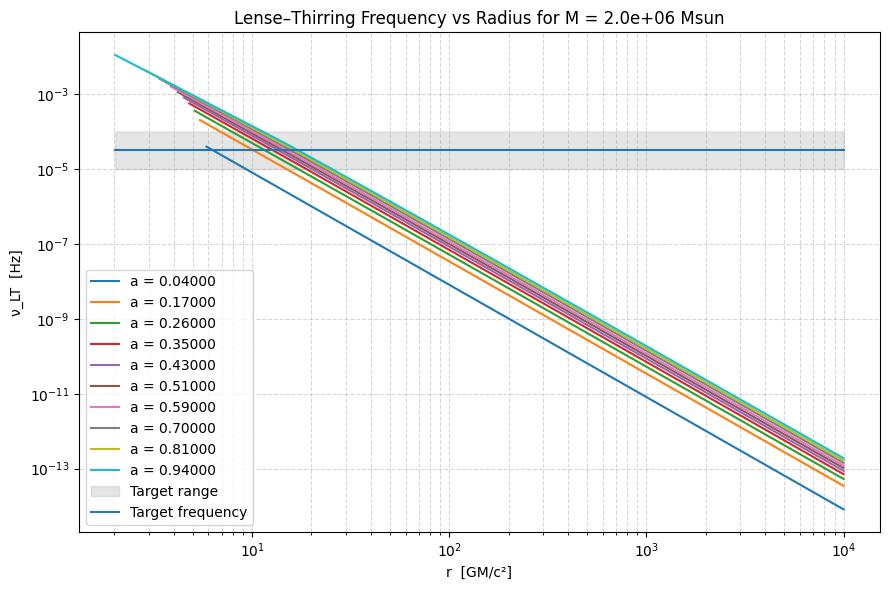

In [42]:
# -----------------------------
# PLOT 1: ν_LT(r) FOR DIFFERENT SPINS
# -----------------------------
a_selected = select(a_match, 10)
title = f"Lense–Thirring Frequency vs Radius for M = {M_bh:.1e} Msun"
label = "ν_LT  [Hz]"
plot_nu_vs_r(a_selected, M_bh, nu0, target_min, target_max, label, title, nu_LT)


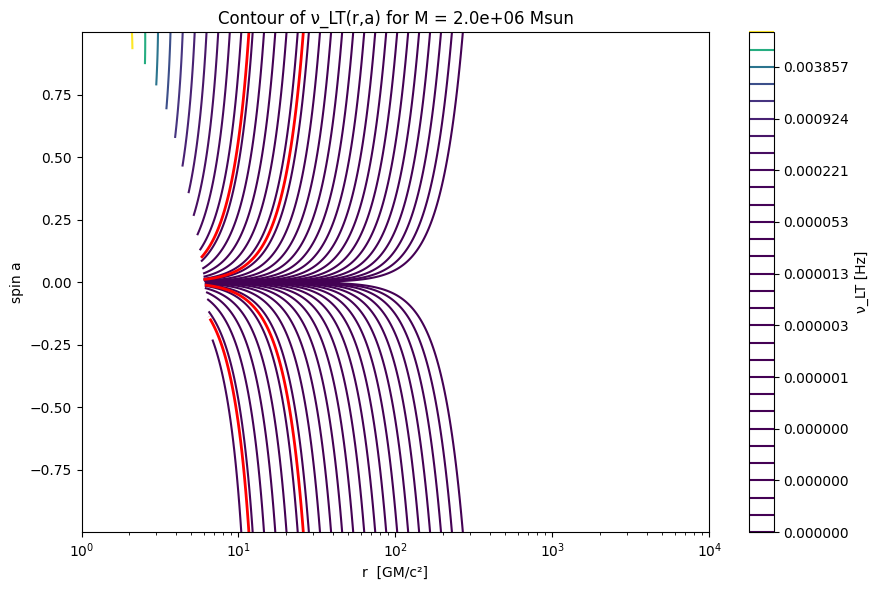

In [43]:
# -----------------------------
# PLOT 2: CONTOUR (r,a) → ν_LT
# -----------------------------
# Finer parameter grids
a_grid = np.linspace(-0.999, 0.999, 400)
r_grid2 = np.exp(np.linspace(np.log(1), np.log(1e4), 500))

A, R = np.meshgrid(a_grid, r_grid2)

# Compute ISCO for each spin
isco_vals = np.array([r_isco(a) for a in a_grid])   # 1D, length = len(a_grid)

# Prepare empty frequency grid
freq_grid = np.zeros((len(r_grid2), len(a_grid)))   # 2D array

# Fill manually (non-vectorized loops)
for j, a in enumerate(a_grid):
    r_isco_current = isco_vals[j]
    for i, r in enumerate(r_grid2):
        if r < r_isco_current:
            freq_grid[i, j] = np.nan   # mask later
        else:
            freq_grid[i, j] = nu_LT(r, a, M_bh)   # safe, scalar-by-scalar
freq_grid = np.ma.masked_invalid(freq_grid)

plt.figure(figsize=(9,6))
levels = np.logspace(-8, -2, 30)

cs = plt.contour(R, A, freq_grid, levels=levels, cmap="viridis")

# Highlight target band
plt.contour(R, A, freq_grid, levels=[target_min], colors='red', linewidths=2)
plt.contour(R, A, freq_grid, levels=[target_max], colors='red', linewidths=2)

plt.xscale("log")
plt.xlabel("r  [GM/c²]")
plt.ylabel("spin a")
plt.title(f"Contour of ν_LT(r,a) for M = {M_bh:.1e} Msun")
plt.colorbar(cs, label="ν_LT [Hz]")
plt.tight_layout()
plt.show()


##### second, periastron precession

In [44]:
#let's look for all the matching combinations of parameters
per_matches = find_match(a_range, r_ranges, nu_per)
stampa(per_matches)

Found 79 matches:
a=0.0, r=39.14589513639185 R_g → ν=3.316130186829759e-05 Hz
a=0.02, r=39.18897419750982 R_g → ν=3.291922107203596e-05 Hz
a=0.03, r=39.027007252411515 R_g → ν=3.3191935093383437e-05 Hz
a=0.04, r=39.22802466980143 R_g → ν=3.268747024781377e-05 Hz
a=0.05, r=39.06353329192467 R_g → ν=3.2962885458643406e-05 Hz
a=0.06, r=38.8983843940147 R_g → ν=3.32431453860164e-05 Hz
a=0.07, r=39.09578531441549 R_g → ν=3.2744474265784655e-05 Hz
a=0.08, r=38.92801058874056 R_g → ν=3.3027772176182026e-05 Hz
a=0.09, r=38.75953994519951 R_g → ν=3.3316194728155615e-05 Hz
a=0.1, r=38.95309949590589 R_g → ν=3.282339928383345e-05 Hz
a=0.11, r=38.781893842683026 R_g → ν=3.311523467914402e-05 Hz
a=0.13, r=38.79942739859979 R_g → ν=3.29256984207693e-05 Hz
a=0.14, r=38.62463110813801 R_g → ν=3.322679902923435e-05 Hz
a=0.15, r=38.81192776063892 R_g → ν=3.2747809946042164e-05 Hz
a=0.16, r=38.63418636006577 R_g → ν=3.305301304111139e-05 Hz
a=0.18, r=38.638386329631686 R_g → ν=3.2891418928327365e-05 Hz
a

/tmp/ipykernel_655/2634601670.py:15: RuntimeWarning: invalid value encountered in sqrt
  factor = np.sqrt(1 - (6)/r + (8*abs(a))/r**1.5 - (3*a**2)/r**2)


same as aboive but with a radius betweeen 35 and 40 Rg
interestinglym, here R decreases with the frequency, while before it increased

/tmp/ipykernel_655/2634601670.py:15: RuntimeWarning: invalid value encountered in sqrt
  factor = np.sqrt(1 - (6)/r + (8*abs(a))/r**1.5 - (3*a**2)/r**2)


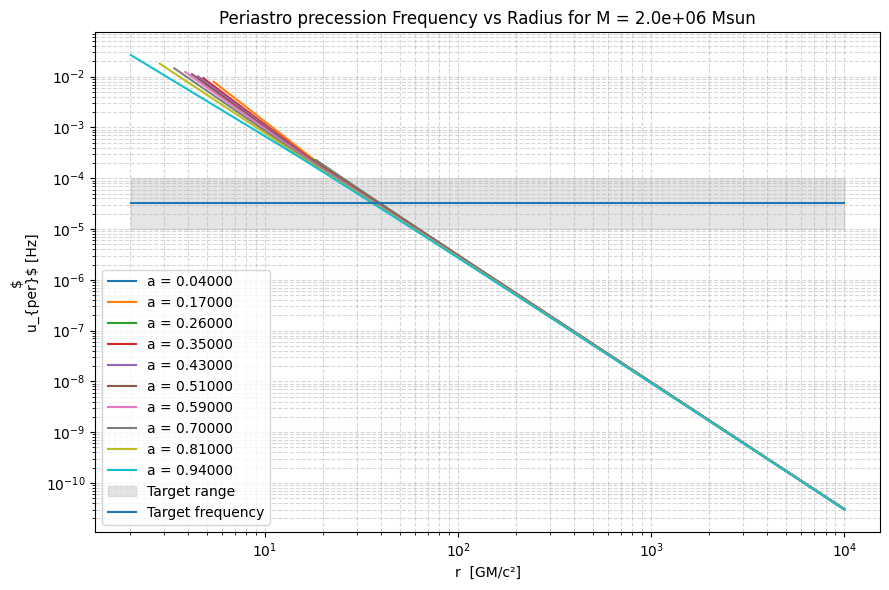

In [45]:
# -----------------------------
# PLOT 1: ν_per(r) FOR DIFFERENT SPINS
# -----------------------------
a_selected = select(a_match, 10)
title = f"Periastro precession Frequency vs Radius for M = {M_bh:.1e} Msun"
label = "$\nu_{per}$ [Hz]"
plot_nu_vs_r(a_selected, M_bh, nu0, target_min, target_max, label, title, nu_per)

##### third, rotation frequency

In [46]:
#let's look for all the matching combinations of parameters
phi_matches = find_match(a_range, r_ranges, nu_phi)
stampa(phi_matches)

Found 139 matches:
a=0.0, r=212.1163663559547 R_g → ν=3.2936395851082136e-05 Hz
a=0.01, r=211.515153909373 R_g → ν=3.307681609831784e-05 Hz
a=0.02, r=210.91089823564235 R_g → ν=3.321895561011762e-05 Hz
a=0.02, r=212.88121335646605 R_g → ν=3.275884190752878e-05 Hz
a=0.03, r=212.26966841449786 R_g → ν=3.290040293907965e-05 Hz
a=0.04, r=211.6549584438407 R_g → ν=3.304372731971119e-05 Hz
a=0.05, r=211.03703321380397 R_g → ν=3.3188853471067976e-05 Hz
a=0.05, r=213.01300334992038 R_g → ν=3.272812941498988e-05 Hz
a=0.06, r=212.38750726454995 R_g → ν=3.287270722285192e-05 Hz
a=0.07, r=211.75866388473796 R_g → ν=3.3019135191826596e-05 Hz
a=0.08, r=211.126418336866 R_g → ν=3.316745482400857e-05 Hz
a=0.08, r=213.1078157429326 R_g → ν=3.270597552518417e-05 Hz
a=0.09, r=210.49071423314965 R_g → ν=3.331770898110558e-05 Hz
a=0.09, r=212.46769697345923 R_g → ν=3.28537808357477e-05 Hz
a=0.1, r=211.8240325466783 R_g → ν=3.300353106448453e-05 Hz
a=0.11, r=211.1767623586381 R_g → ν=3.315527116969287e-05 H

the radius is alwas around 212 Rg
it's way bigger than the values for the other frequencies, and this is obvious since from the formulas above, this is the biggest frequency once the radius is fixed

/tmp/ipykernel_655/2614636931.py:30: UserWarning: Glyph 11 () missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/masterpops/IUSS_tesi/PITONE/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


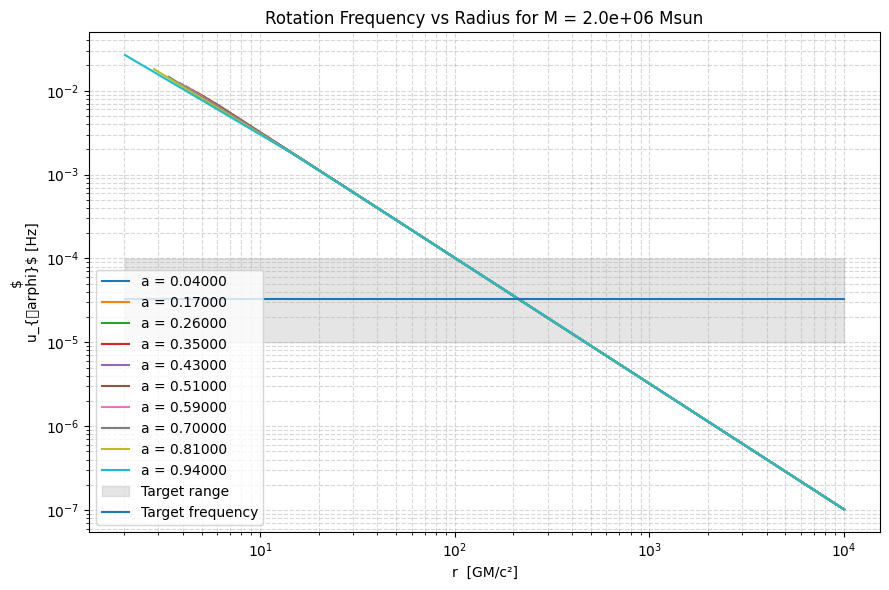

In [47]:
# Plot ν_phi(r) for different spins
a_selected = select(a_match, 10)
title = f"Rotation Frequency vs Radius for M = {M_bh:.1e} Msun"
label = "$\nu_{\varphi}$ [Hz]"
plot_nu_vs_r(a_selected, M_bh, nu0, target_min, target_max, label, title, nu_phi)

#### now let's study varying masses in the range 6-7

In [48]:
def stmp_mass(matches):
    print(f"Found {len(matches)} matches:")
    for m in matches:
        print(f"M=10^{np.log10(m[0])} M_sun, a={m[1]}, r={m[2]} R_g → ν={m[3]} Hz")

In [49]:
Ms = 10**(np.linspace(6,7, 11))

In [50]:
#let's look for all the matching combinations of parameters
M_LT_matches = find_match(a_range, r_ranges, nu_LT, Ms)

In [51]:
stmp_mass(M_LT_matches)

Found 690 matches:
M=10^6.0 M_sun, a=0.03, r=7.1753411896117765 R_g → ν=3.2695952491194544e-05 Hz
M=10^6.0 M_sun, a=0.05, r=8.472096624604424 R_g → ν=3.2955294333092064e-05 Hz
M=10^6.0 M_sun, a=0.06, r=8.994924851034341 R_g → ν=3.2972361786412496e-05 Hz
M=10^6.0 M_sun, a=0.07, r=9.461819087269786 R_g → ν=3.298011785644959e-05 Hz
M=10^6.0 M_sun, a=0.08, r=9.860818350501166 R_g → ν=3.322953435198027e-05 Hz
M=10^6.0 M_sun, a=0.09, r=10.276922069900193 R_g → ν=3.2957928551992366e-05 Hz
M=10^6.0 M_sun, a=0.1, r=10.611134494010736 R_g → ν=3.320044525733246e-05 Hz
M=10^6.0 M_sun, a=0.11, r=10.95635189428016 R_g → ν=3.3111235633306e-05 Hz
M=10^6.0 M_sun, a=0.12, r=11.312939600919735 R_g → ν=3.275025422632468e-05 Hz
M=10^6.0 M_sun, a=0.13, r=11.572236998434287 R_g → ν=3.3082432141826046e-05 Hz
M=10^6.0 M_sun, a=0.14, r=11.83743941726702 R_g → ν=3.32220148002221e-05 Hz
M=10^6.0 M_sun, a=0.15, r=12.108676142435597 R_g → ν=3.319376268024615e-05 Hz
M=10^6.0 M_sun, a=0.16, r=12.386078890379059 R_g →

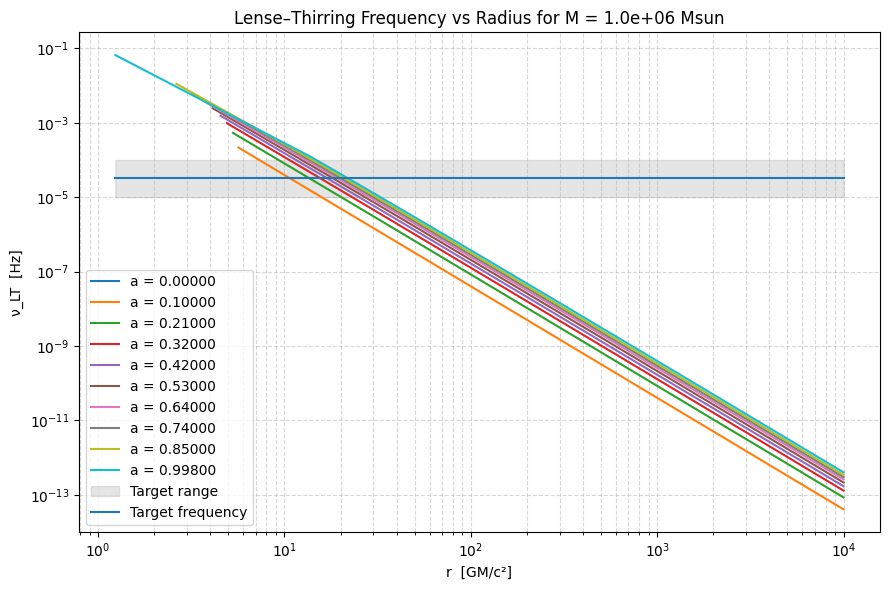

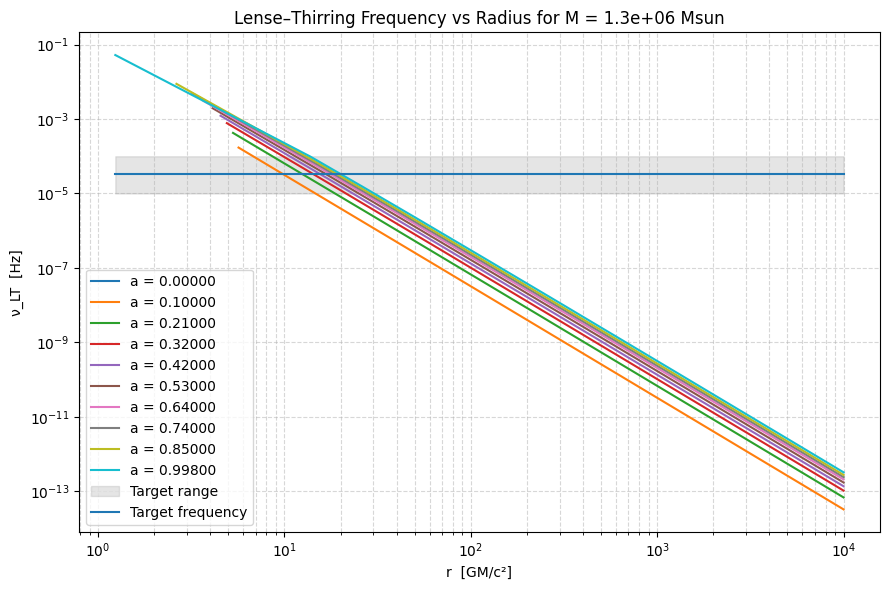

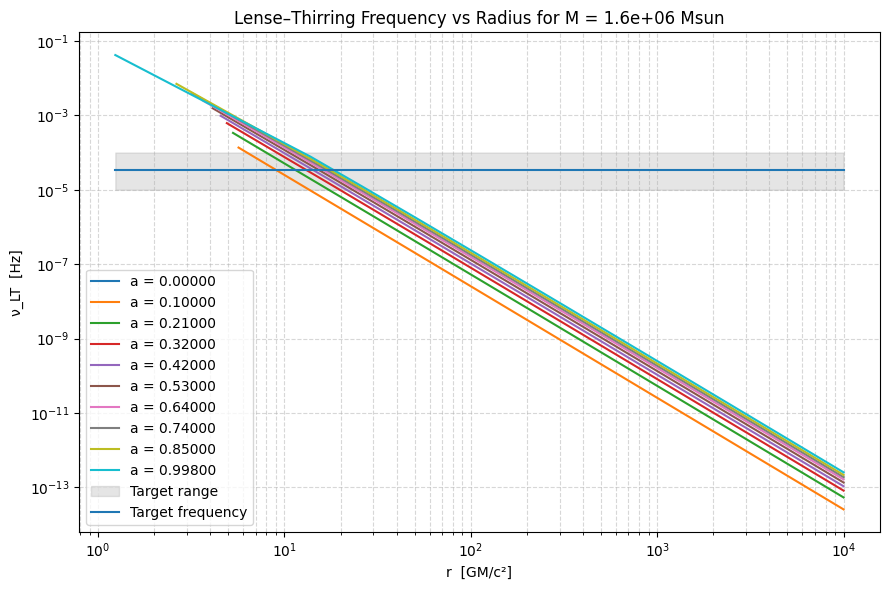

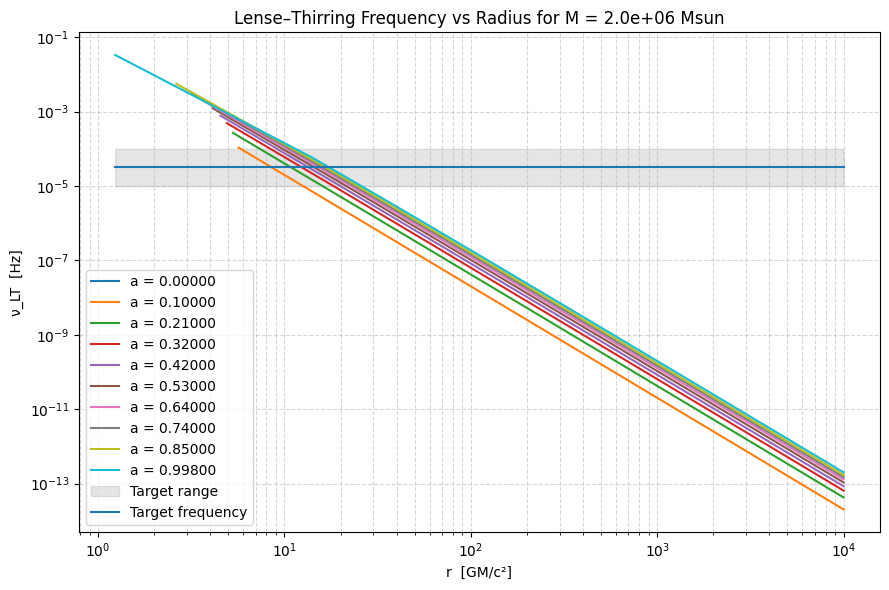

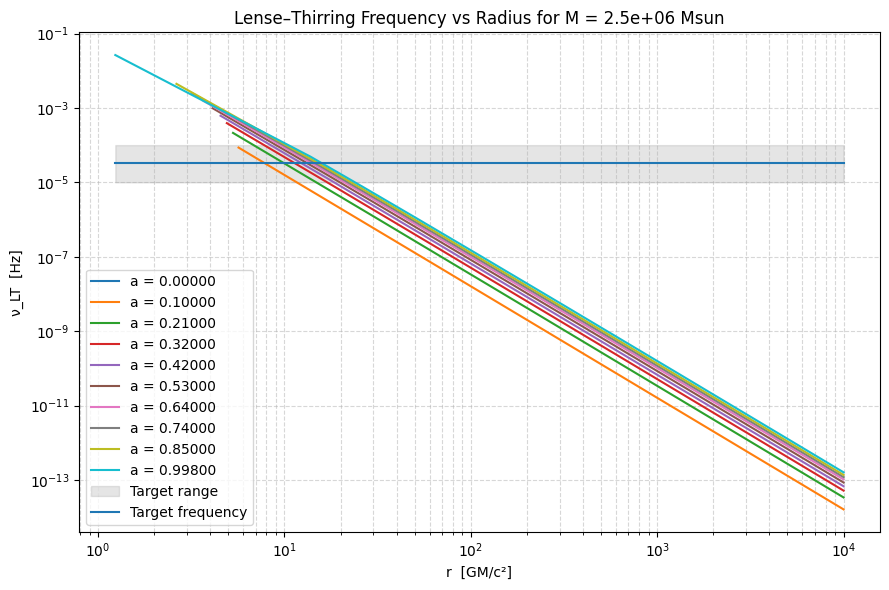

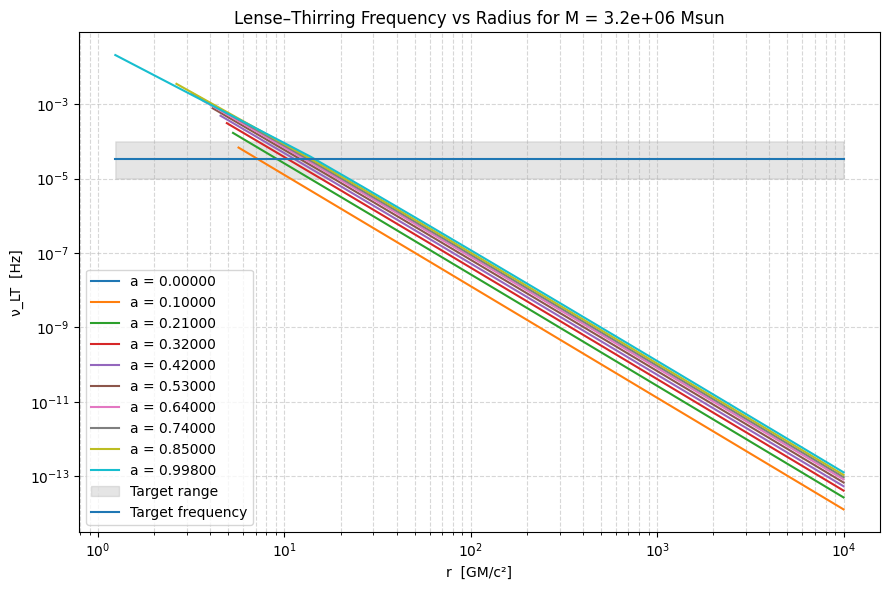

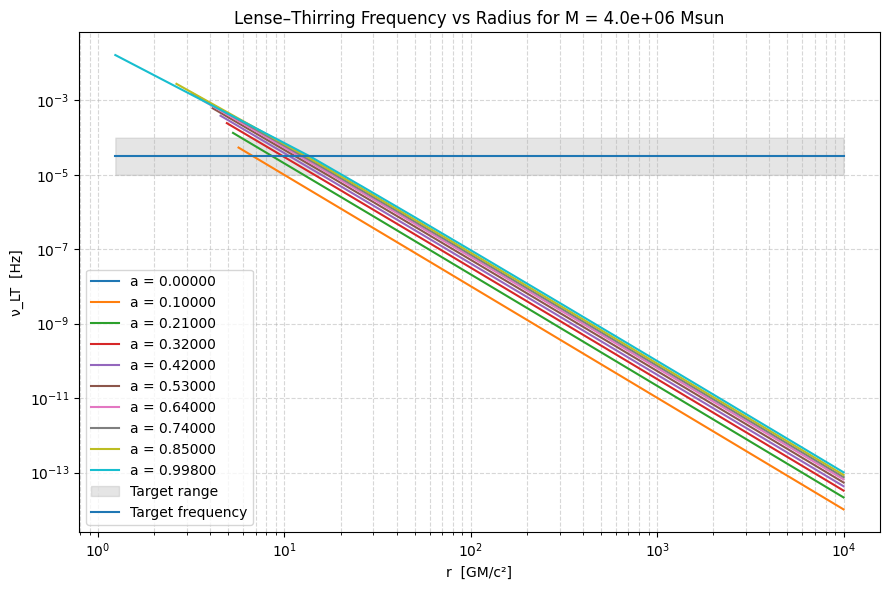

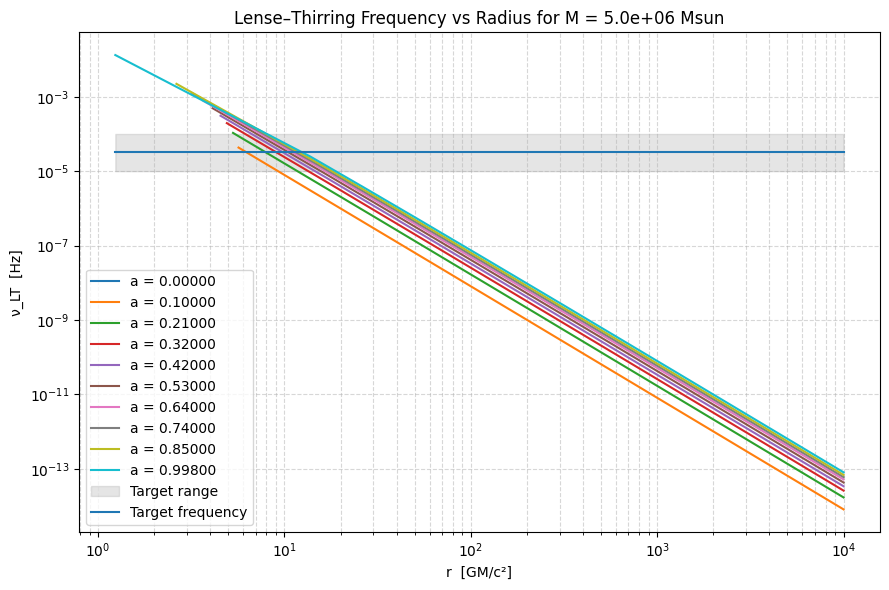

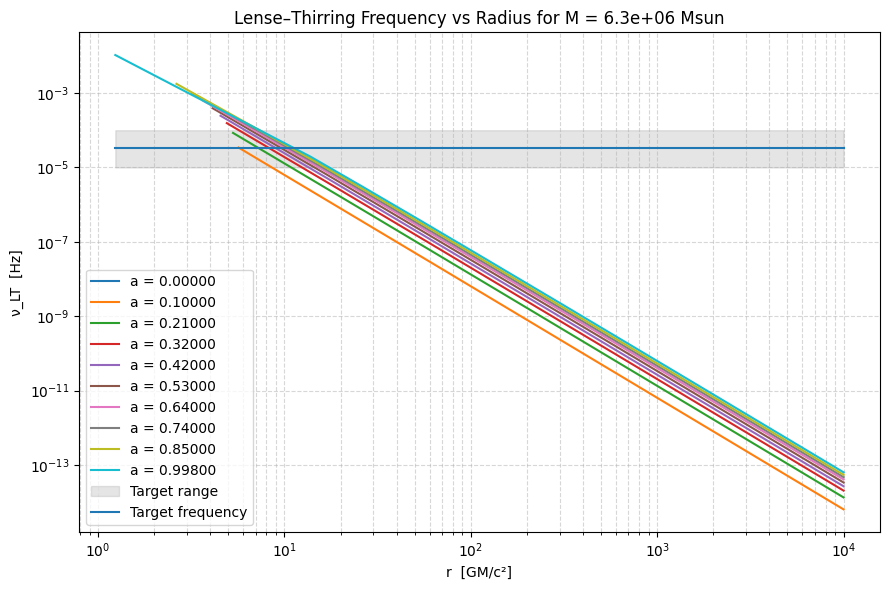

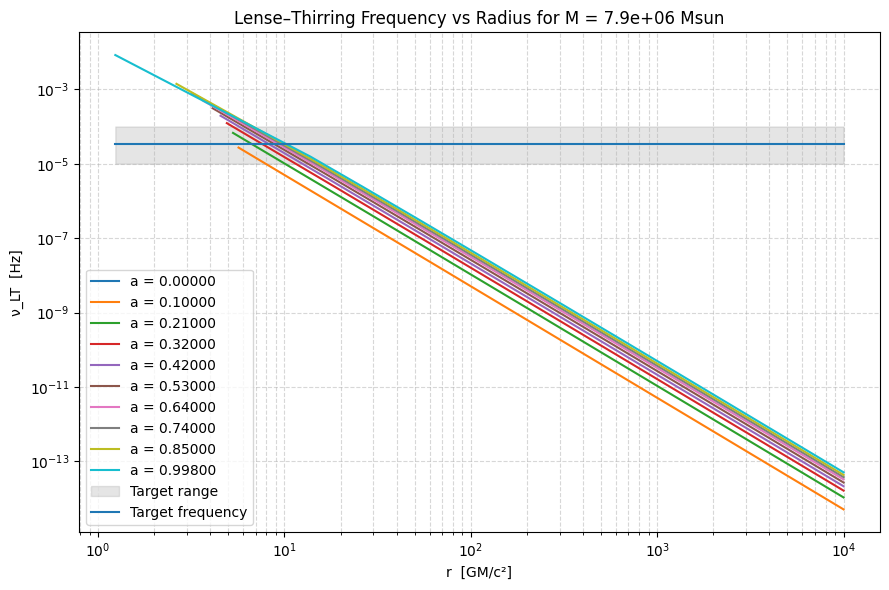

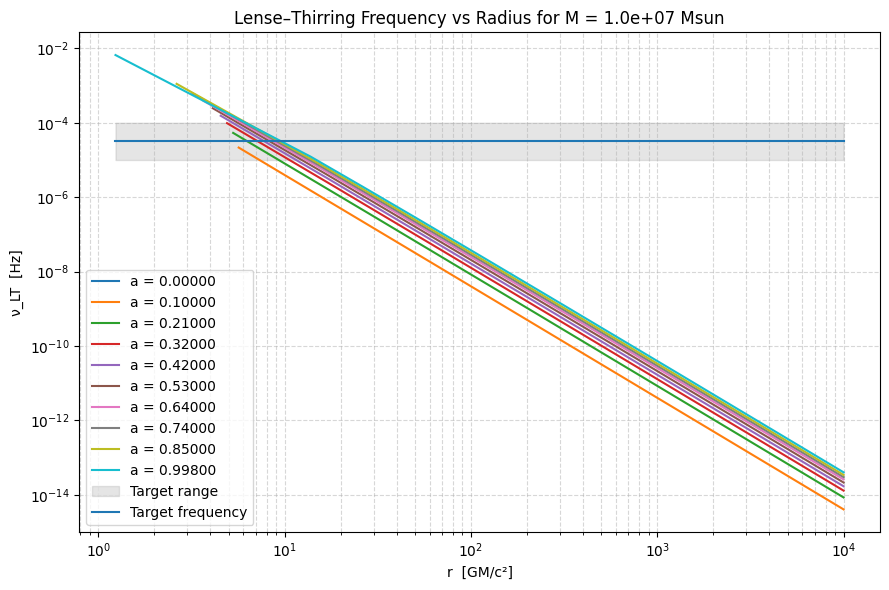

In [52]:
a_selected = select(a_range, 10)
for M in Ms:
    title = f"Lense–Thirring Frequency vs Radius for M = {M:.1e} Msun"
    label = "ν_LT  [Hz]"
    plot_nu_vs_r(a_selected, M, nu0, target_min, target_max, label, title, nu_LT)

### SECOND MODEL: INNER PRECESSING FLOW

this model assumes a truncated disc and an hot optically thick inner flow misaligned with respect to the spiunning hole and therefore precessing around it.
the precession is assumed to be a solid body one, with a frequency given by the average of the LT freequencies at the different radii covered by the flow.
This freqeuncy therefore depends on the spin nad mass of the compact object, but also on the value of the inner and outer radii of the flow, and on the density distribution, which is generalli assumed to be a power law (with exponent $\zeta$)

$\nu(a, M, r_{in}, r_{out}, \zeta)$

In [54]:
def nu_prec_solid_body(a, M, r_in, r_out, zeta=0.0):  
    _eps = 1e-14          # small tolerance

    # convert inputs to numpy arrays for safe broadcasting
    a_arr = np.asarray(a, dtype=float)
    r_in_arr = np.asarray(r_in, dtype=float)
    r_out_arr = np.asarray(r_out, dtype=float)
    zeta_arr = np.asarray(zeta, dtype=float)
    
    # mass in kg and gravitational radius Rg = G M / c^2
    Rg = Rg_sun*M
    
    # Prepare output array with broadcasting shape
    shape = np.broadcast(a_arr, r_in_arr, r_out_arr, zeta_arr).shape
    omega = np.full(shape, np.nan, dtype=float)
    
    # Quick guard: invalid radii
    invalid = (r_out_arr <= r_in_arr) | (r_in_arr <= 0)
    if np.any(invalid):
        # we'll leave those entries as NaN, but continue computing valid ones
        pass
    
    # compute common factors safely on broadcasted arrays
    # To avoid invalid broadcasting complexities, create full arrays via broadcast_to
    A = np.broadcast_to(a_arr, shape)
    RIN = np.broadcast_to(r_in_arr, shape)
    ROUT = np.broadcast_to(r_out_arr, shape)
    Z = np.broadcast_to(zeta_arr, shape)
    
    # Denominator checks
    denom_pref = 1.0 + 2.0 * Z
    denom_pref_bad = np.isclose(denom_pref, 0.0, atol=_eps)
    
    power1 = Z + 0.5
    power2 = 2.5 - Z  # 5/2 - zeta
    denom_power_term = 1.0 - (RIN / ROUT)**(power2)
    denom_power_bad = np.isclose(denom_power_term, 0.0, atol=_eps)
    
    # valid mask: rout > rin, denominators ok
    valid = (~invalid) & (~denom_pref_bad) & (~denom_power_bad)
    
    if not np.any(valid):
        omega / (2*np.pi)
    
    # compute safe quantities where valid
    # factor = (2 * a * c / Rg) * ((5 - 2 zeta) / (1 + 2 zeta))
    prefactor = (2.0 * A * c / Rg) * ((5.0 - 2.0 * Z) / denom_pref)
    
    # numerator: 1 - (r_in / r_out)^(zeta + 1/2)
    num = 1.0 - (RIN / ROUT)**(power1)
    
    # denominator: r_out^(5/2 - zeta) * r_in^(1/2 - zeta) * (1 - (r_in/r_out)^(5/2 - zeta))
    denom = (ROUT**(power2)) * (RIN**(0.5 - Z)) * denom_power_term
    
    # compute omega only for valid entries
    omega[valid] = prefactor[valid] * (num[valid] / denom[valid])
    
    # a == 0 => omega = 0 (ensured by prefactor). if tiny numerical noise appears, force exact zero:
    omega[np.isclose(A, 0.0, atol=_eps) & valid] = 0.0
    nu = omega / (2.0 * np.pi)

    return nu


In [55]:
a_range = np.linspace(-95, 95, 191)  # Spins
a_range = a_range/100
a_range = np.insert(a_range, 0, -0.998)  # add extreme retrograde spin
a_range = np.append(a_range, 0.998)      # add extreme prograde spin

r_in_list = []
for a in a_range:
    r0 = r_isco(a)
    rvals = np.exp(np.linspace(np.log(r0), np.log(5e2), 200))
    r_in_list.append(rvals)
# stack into (Na, Nr)
r_in_grid = np.array(r_in_list)

# build r_out grid for all spins & all r_in
r_out_list = []
for i, a in enumerate(a_range):
    row = []
    for rin in r_in_grid[i]:
        rvals = np.exp(np.linspace(np.log(rin*1.05), np.log(1e3), 500))
        row.append(rvals)
    r_out_list.append(row)
r_out_grid = np.array(r_out_list)  # shape (Na, Nr_in, Nr_out)

zetas = np.array([-0.45, 0, 0.5])

#### fixed mass

In [56]:
A     = a_range[:, None, None, None]      # (Na,1,1,1)
RIN   = r_in_grid[:, :, None, None]       # (Na,Nr,1,1)
ROUT  = r_out_grid[:, :, :, None]         # (Na,Nr,No,1)
ZETA  = zetas[None, None, None, :]        # (1,1,1,Nz)

freqs = nu_prec_solid_body(A, M_bh, RIN, ROUT, ZETA)
mask = np.isfinite(freqs) & (np.abs(freqs - nu0) < tol)

In [57]:
idx = np.where(mask)

print(f"FOUNHD {len(idx[0])} combinations matching target frequency")
for i_a, i_rin, i_rout, i_z in zip(*idx):

    a_val    = a_range[i_a]
    z_val    = zetas[i_z]

    rin_val  = RIN[i_a, i_rin, 0, 0]
    rout_val = ROUT[i_a, i_rin, i_rout, 0]

    f_val    = freqs[i_a, i_rin, i_rout, i_z]

    print(f"a={a_val}, zeta={z_val}, "
          f"r_in={rin_val}, r_out={rout_val}, "
          f"freq={f_val} Hz")

FOUNHD 10941 combinations matching target frequency
a=0.04, zeta=0.5, r_in=5.868725418131567, r_out=6.418752942222656, freq=3.285216763443502e-05 Hz
a=0.04, zeta=0.5, r_in=6.0012873896632035, r_out=6.36566348465729, freq=3.2913278476960975e-05 Hz
a=0.05, zeta=0.5, r_in=5.835703087865181, r_out=7.363765535609398, freq=3.3322000707958666e-05 Hz
a=0.05, zeta=0.5, r_in=5.835703087865181, r_out=7.439337394789436, freq=3.2795734317193356e-05 Hz
a=0.05, zeta=0.5, r_in=5.9676883692047475, r_out=7.372806845678042, freq=3.2929312344662005e-05 Hz
a=0.05, zeta=0.5, r_in=6.102658743210612, r_out=7.308836486905419, freq=3.304167261626417e-05 Hz
a=0.05, zeta=0.5, r_in=6.2406817233065155, r_out=7.24736984419028, freq=3.3132776198921415e-05 Hz
a=0.05, zeta=0.5, r_in=6.381826349857867, r_out=7.188352937302599, freq=3.3202630440749123e-05 Hz
a=0.05, zeta=0.5, r_in=6.381826349857867, r_out=7.260822775553867, freq=3.269662475211526e-05 Hz
a=0.05, zeta=0.5, r_in=6.526163224706375, r_out=7.131734201255154, f

we found solutions for
* spin greater than 0.4
* only z=0.5
* r_in increasing with spin spin 
* r_out always close to r_in, about 1 R_g distant

###### plot per coppie (a,r_in)

/tmp/ipykernel_655/2649621684.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = f"a={a_val}, r_in={float(rin_val):.4f}"


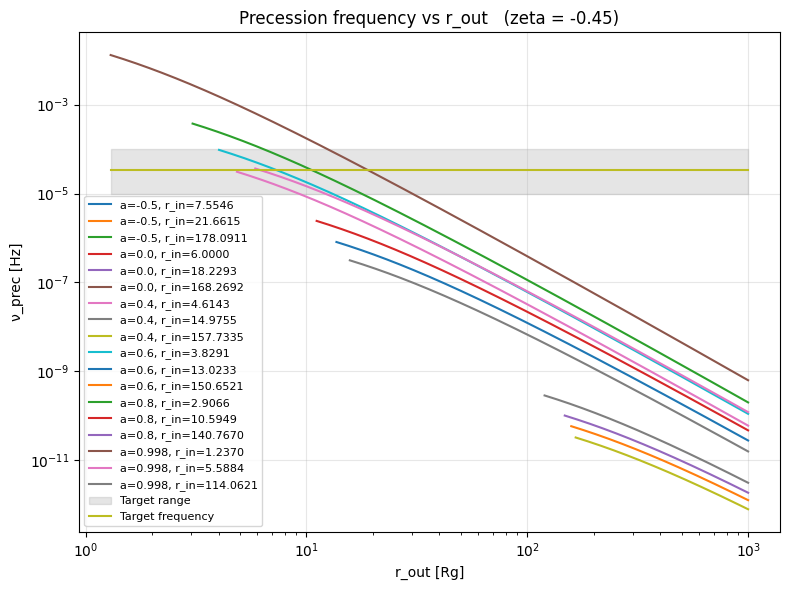

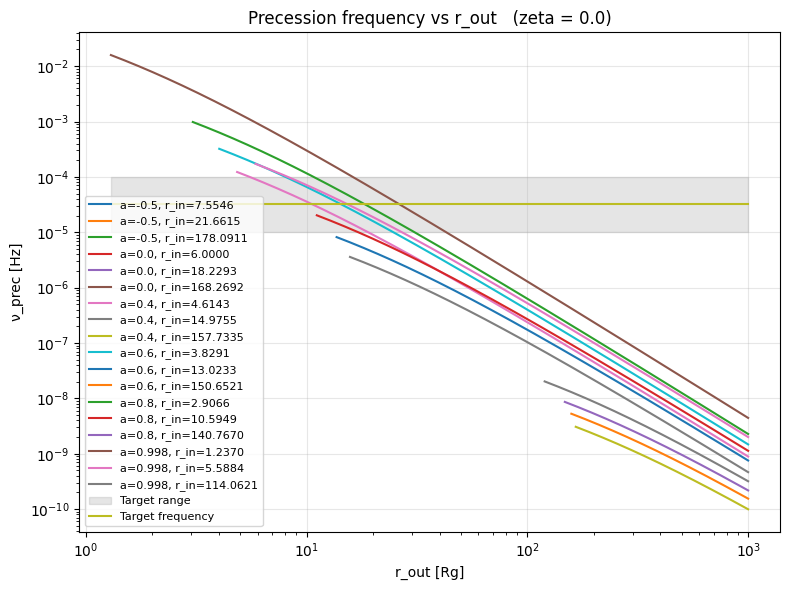

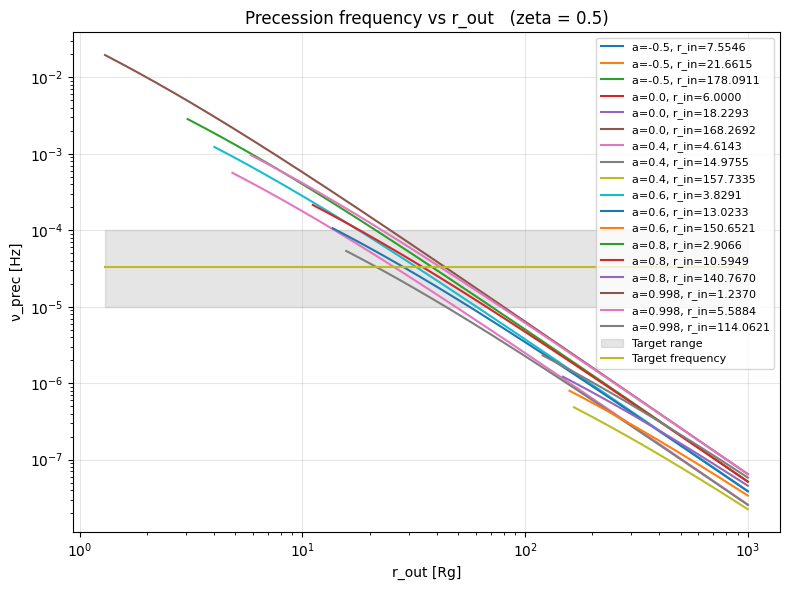

In [58]:
# Choose indices to plot
a_chosen = np.array([-0.5, 0, 0.4, 0.6, 0.8, 0.998])         # example
rin_idxs  = [0, 50, 150]                    # example
colors = plt.cm.viridis(np.linspace(0, 1, len(a_chosen)))


# Loop over zeta values
for iz, zeta in enumerate(zetas):
    plt.figure(figsize=(8, 6))
    
    for a_val in a_chosen:
        ia = np.where(a_range == a_val)
        
        for ir in rin_idxs:
            rin_val  = RIN[ia, ir, 0, 0]        # scalar
            rout_vals = ROUT[ia, ir, :, 0]      # vector shape (No,)
            freq_vals = freqs[ia, ir, :, iz]    # vector shape (No,)
            
            # plot only valid positive frequencies
            mask2 = np.isfinite(freq_vals) & (freq_vals > 0)
            
            label = f"a={a_val}, r_in={float(rin_val):.4f}"
            plt.plot(rout_vals[mask2], freq_vals[mask2], label=label)

            
    
    # Target frequency band
    plt.fill_between(r_out_grid[-1, 0], target_min, target_max, color='gray', alpha=0.2,
                    label="Target range")
    plt.plot(r_out_grid[-1, 0], np.ones_like(rout_vals[mask2])*nu0, label="Target frequency")

    plt.title(f"Precession frequency vs r_out   (zeta = {zeta})")
    plt.xlabel("r_out [Rg]")
    plt.ylabel("ν_prec [Hz]")
    plt.xscale("log")
    plt.yscale("log")
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


###### plot r_in fixed, different a

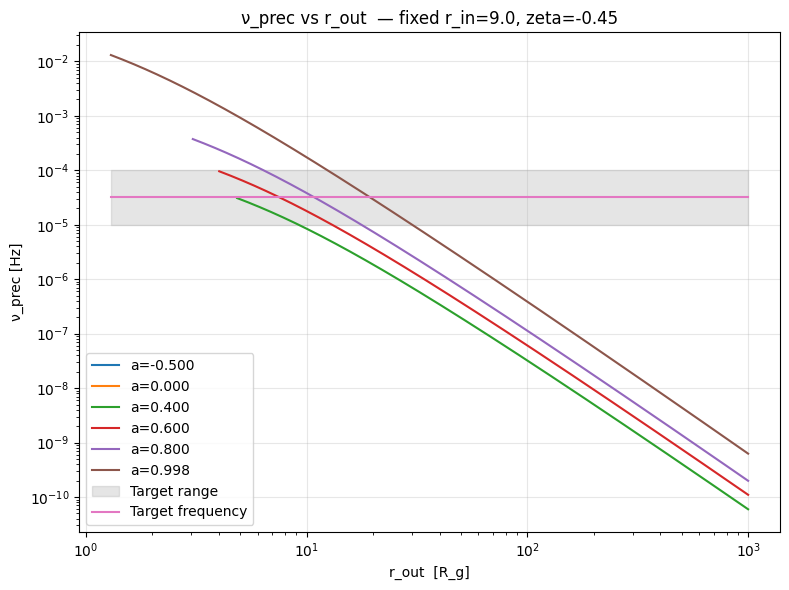

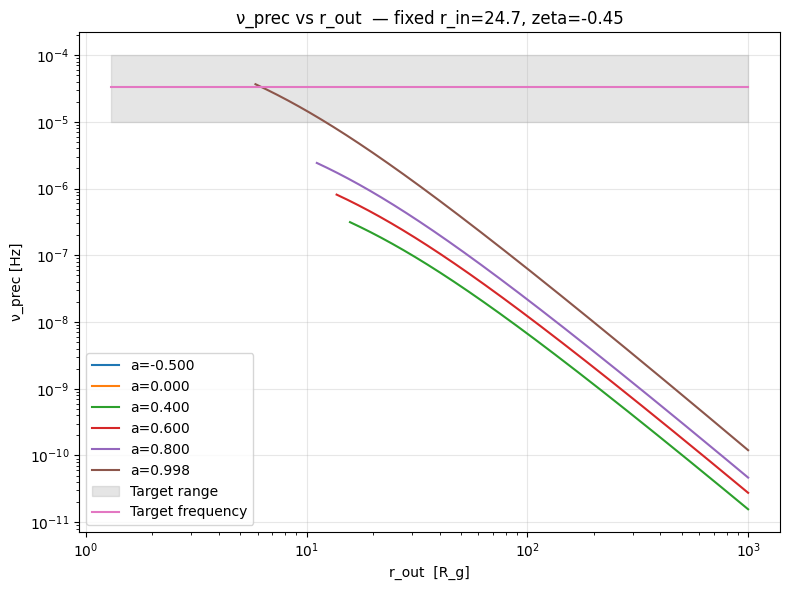

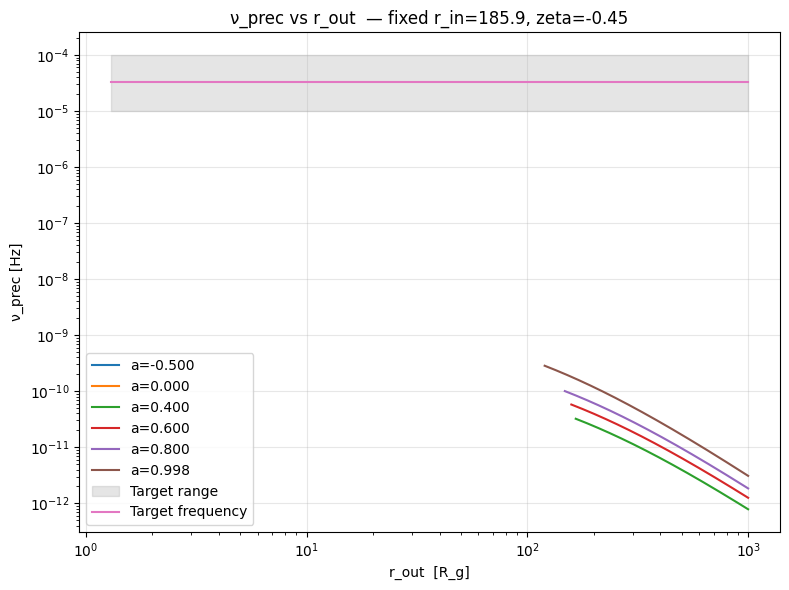

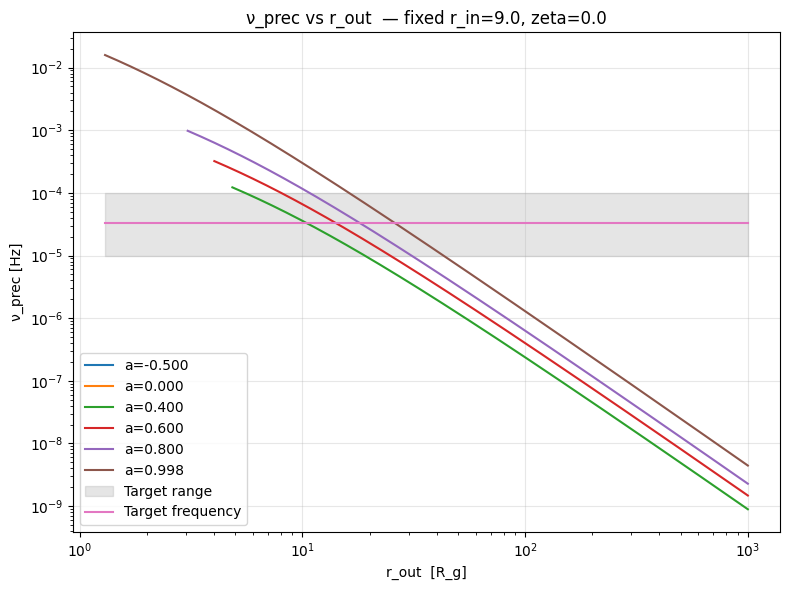

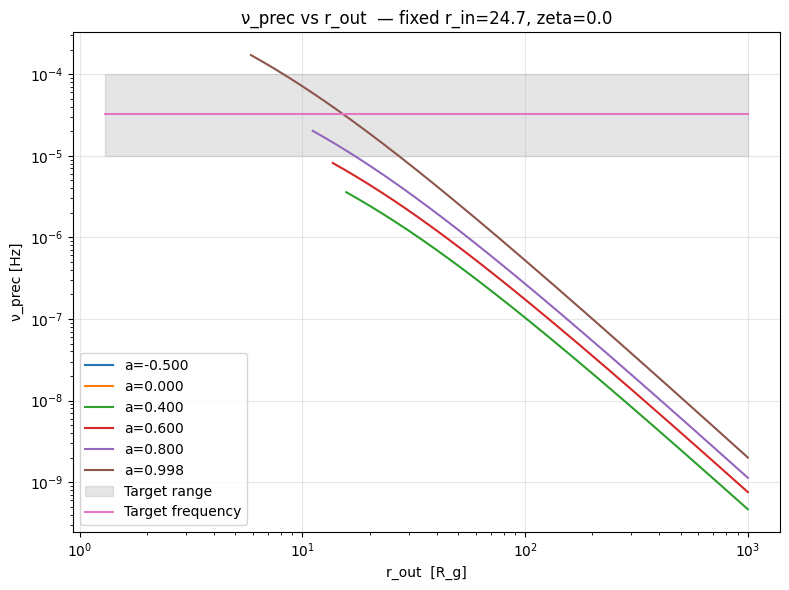

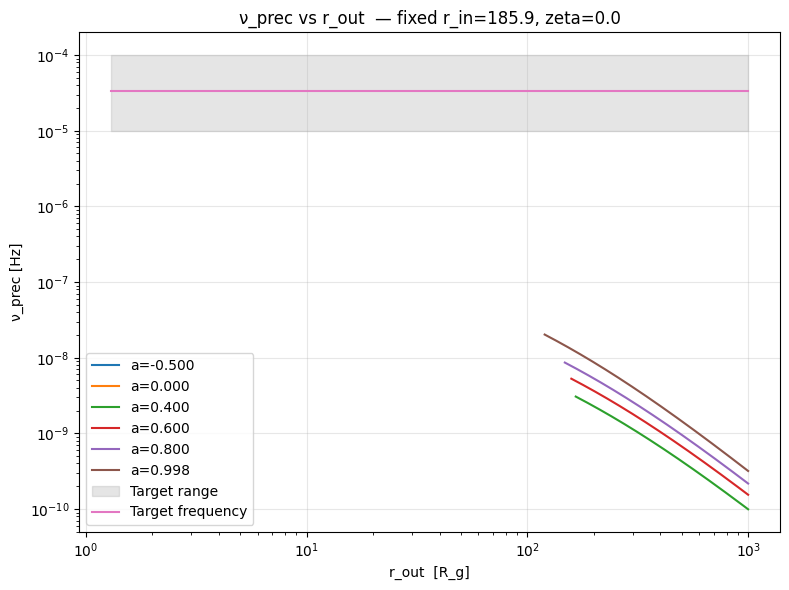

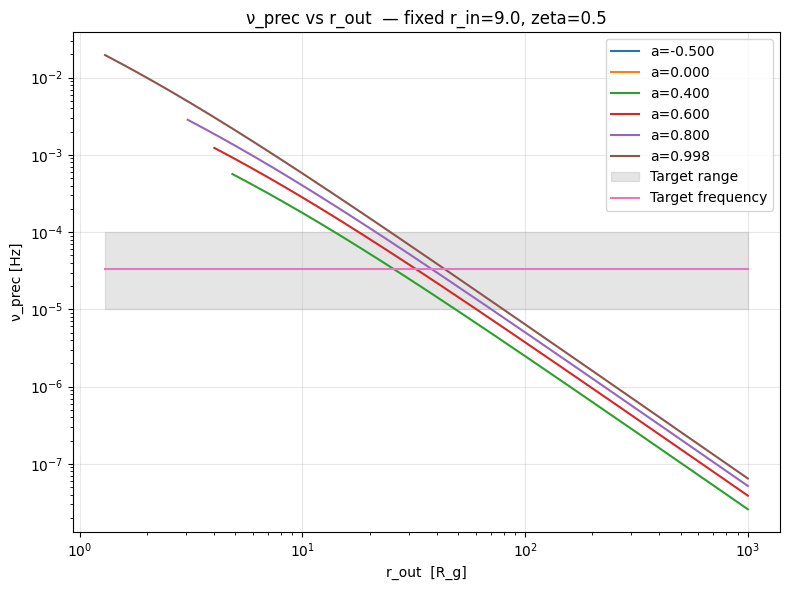

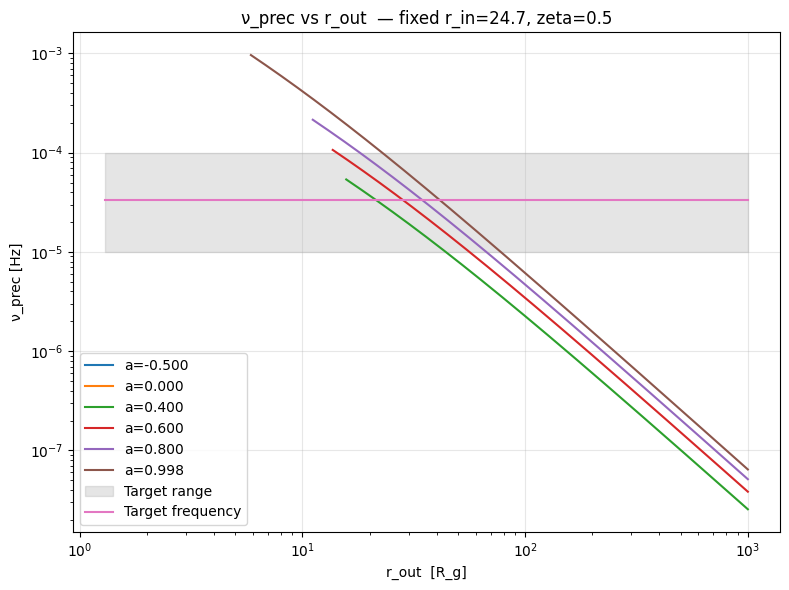

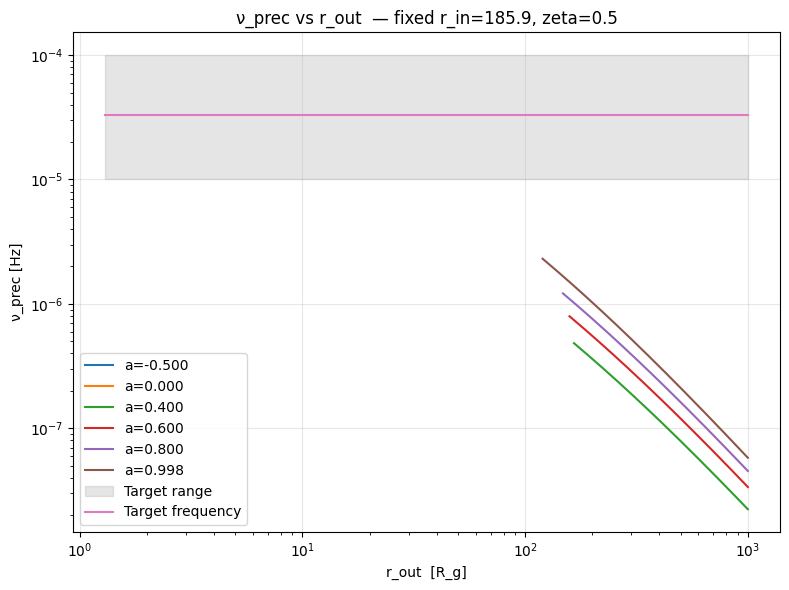

In [59]:
for iz, zeta in enumerate(zetas):

    for ir in rin_idxs:
        rin_val = RIN[0, ir, 0, 0]  # same for all spins
        
        plt.figure(figsize=(8, 6))

        for a_val in a_chosen:
            ia = np.where(a_range == a_val)
            
            rout_vals = ROUT[ia, ir, :, 0]        # vector
            freq_vals = freqs[ia, ir, :, iz]      # vector

            mask3 = np.isfinite(freq_vals) & (freq_vals > 0)
            
            plt.plot(rout_vals[mask3], freq_vals[mask3],
                     label=f"a={a_val:.3f}")

        # Target frequency band
        plt.fill_between(r_out_grid[-1, 0], target_min, target_max, color='gray', alpha=0.2,
                        label="Target range")
        plt.plot(r_out_grid[-1, 0], np.ones_like(rout_vals[mask3])*nu0, label="Target frequency")


        plt.title(f"ν_prec vs r_out  — fixed r_in={rin_val:.1f}, zeta={zeta}")
        plt.xlabel("r_out  [R_g]")
        plt.ylabel("ν_prec [Hz]")
        plt.xscale("log")
        plt.yscale("log")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

###### plot a fixed, different rins

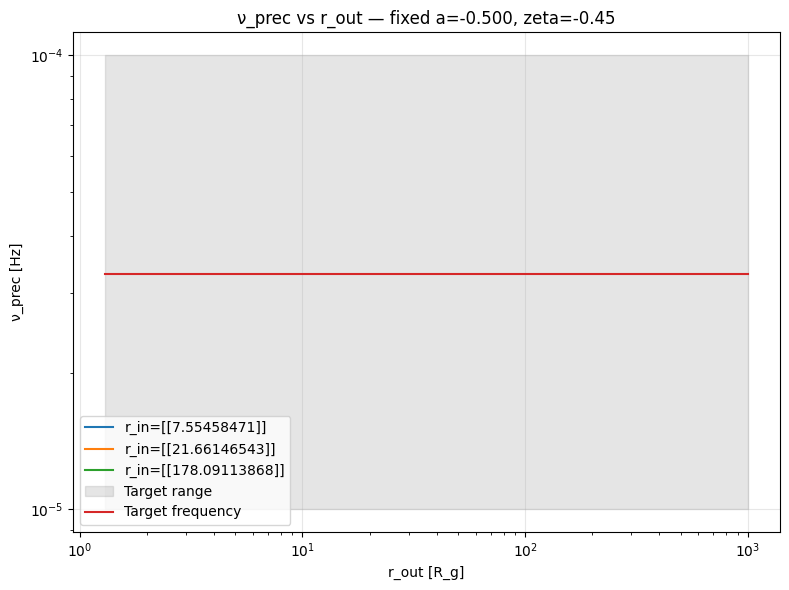

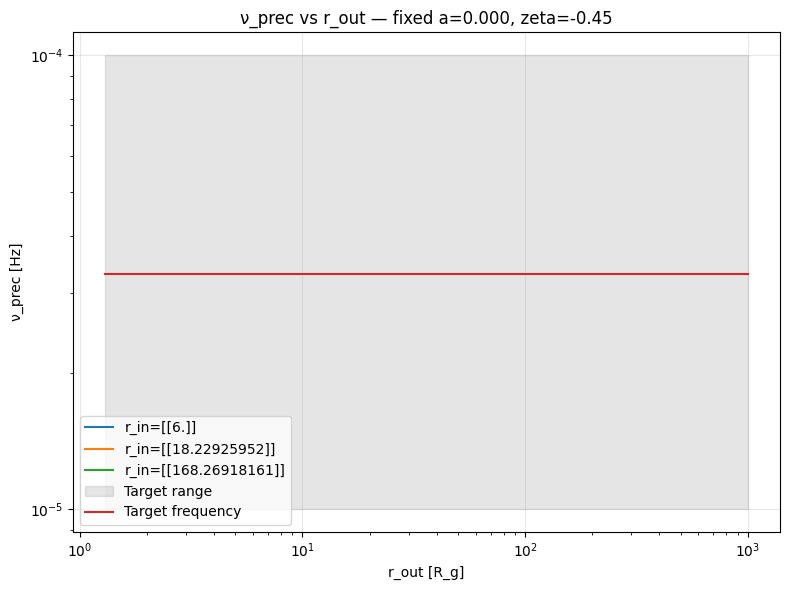

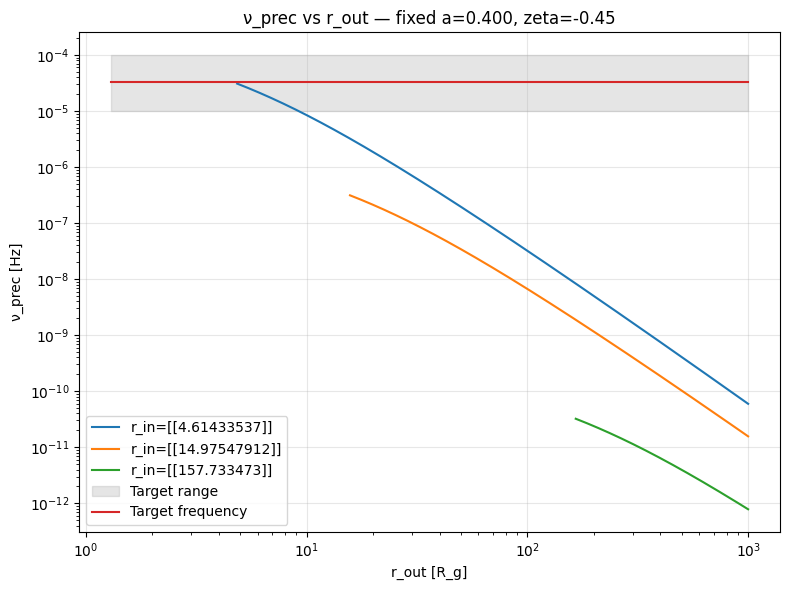

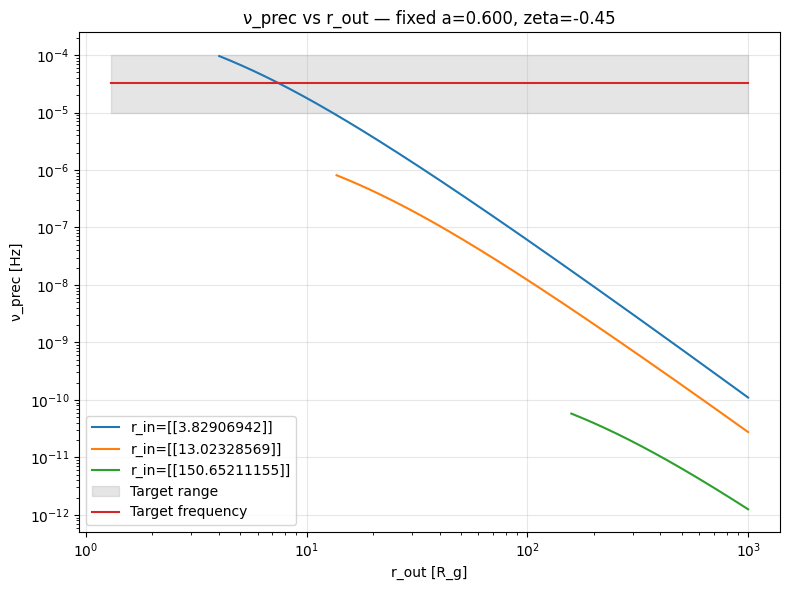

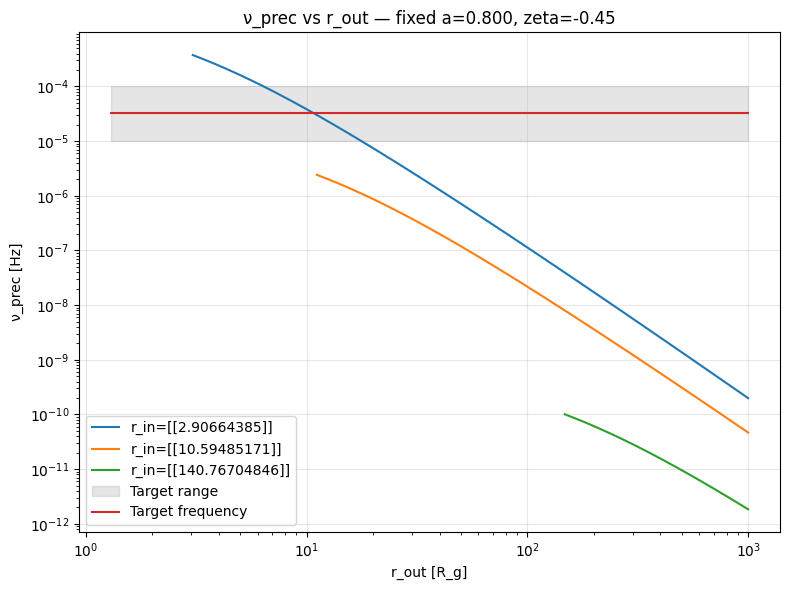

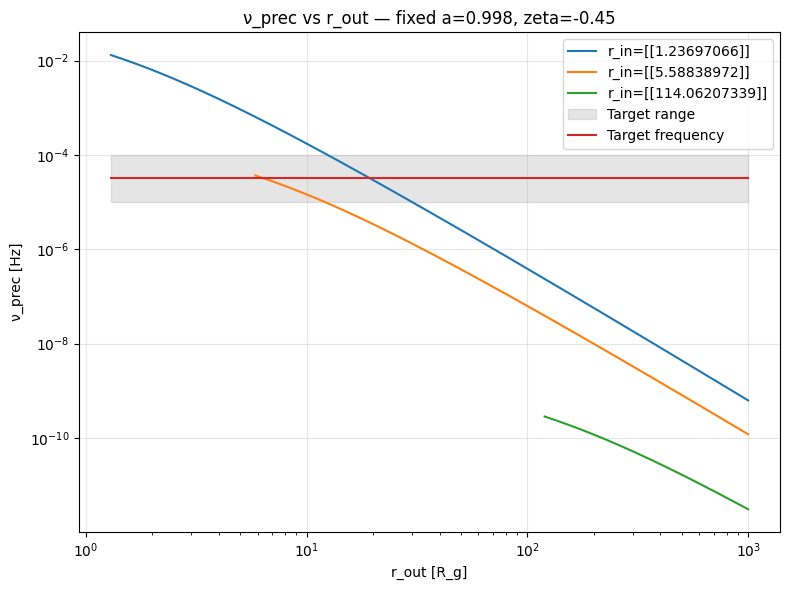

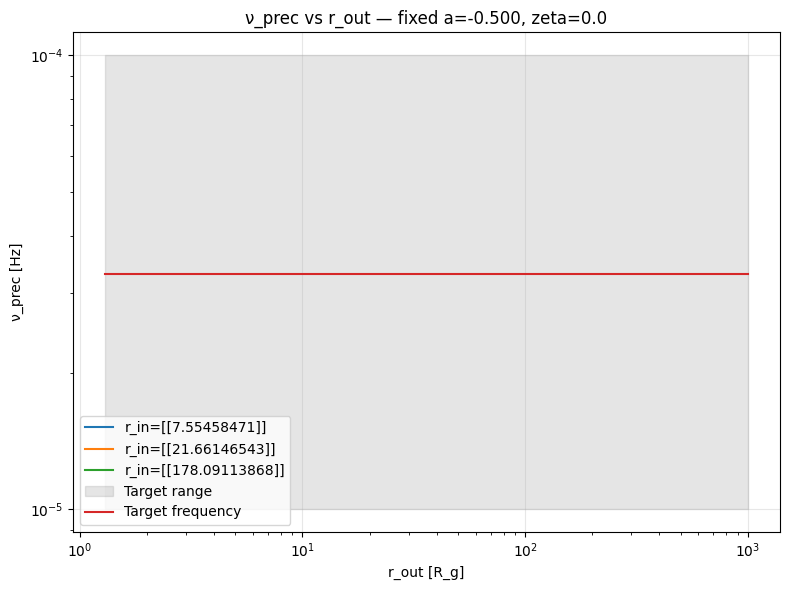

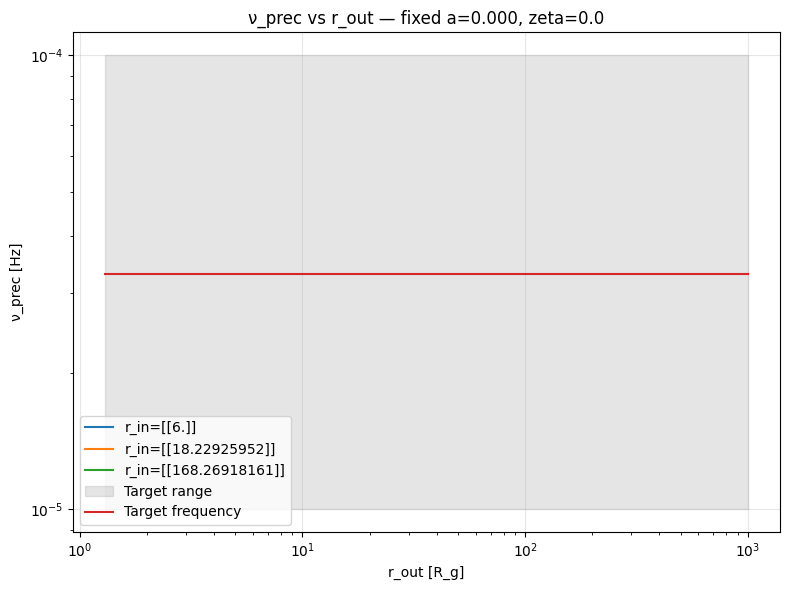

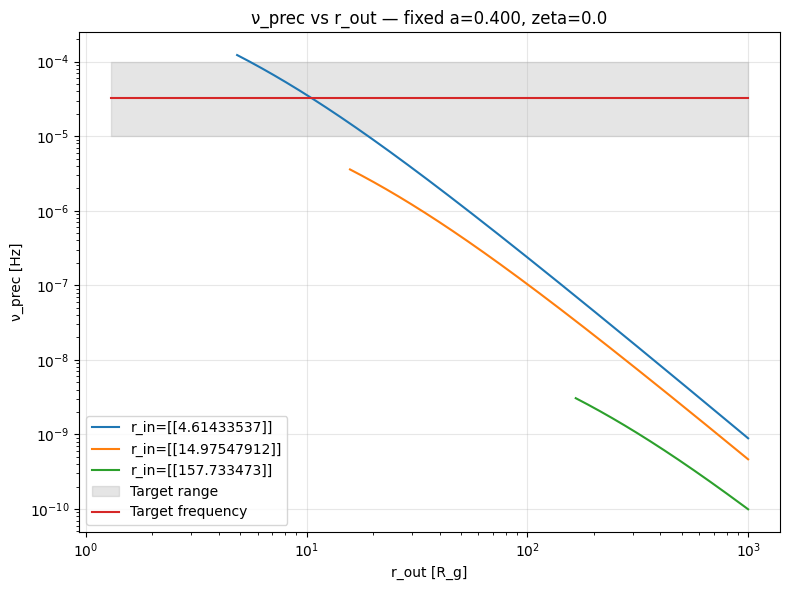

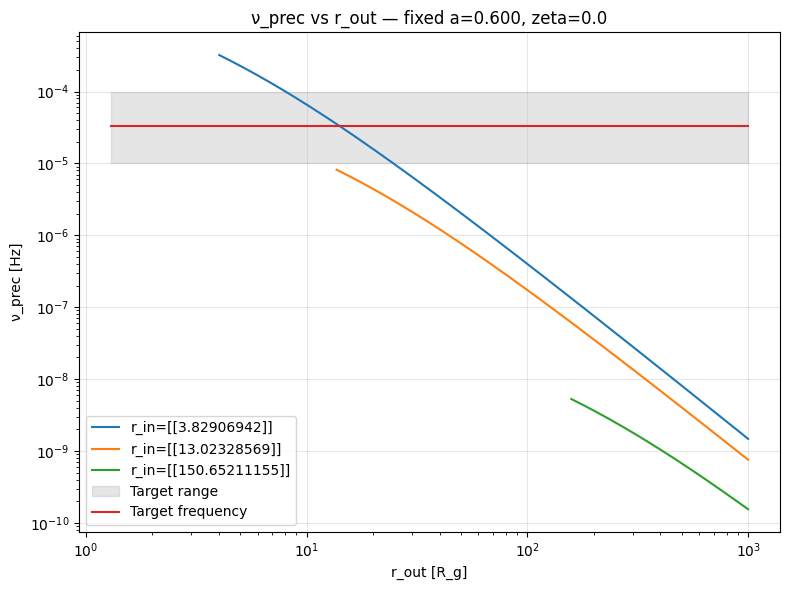

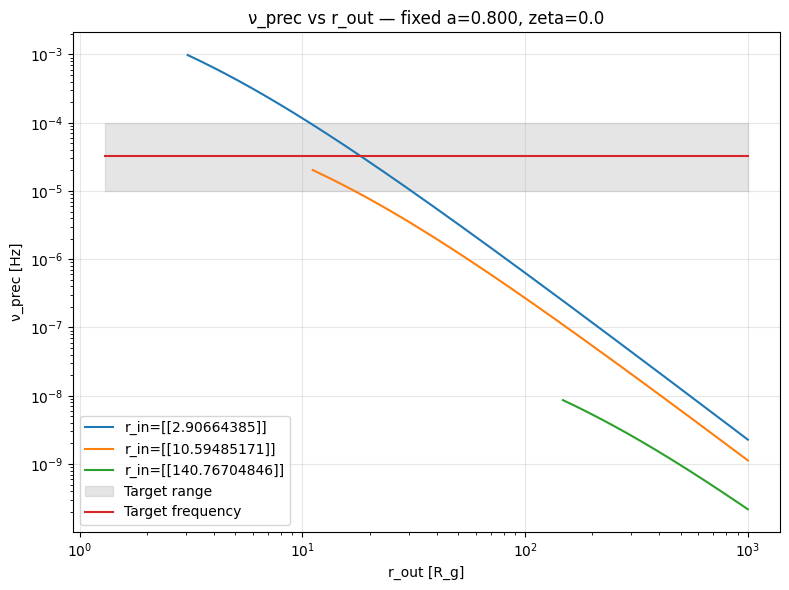

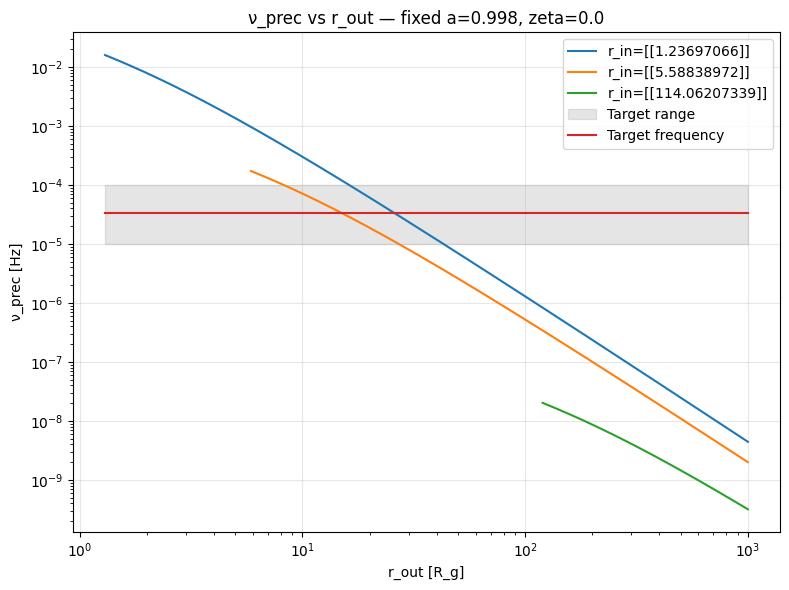

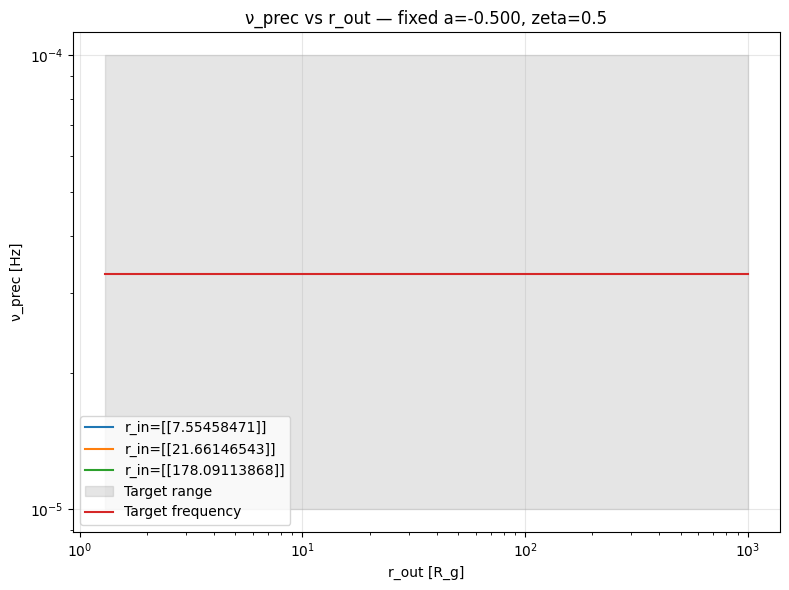

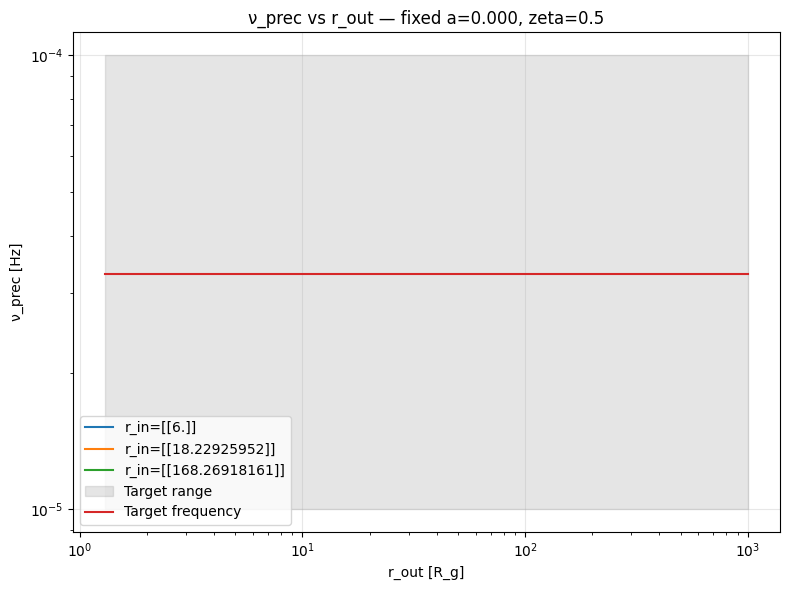

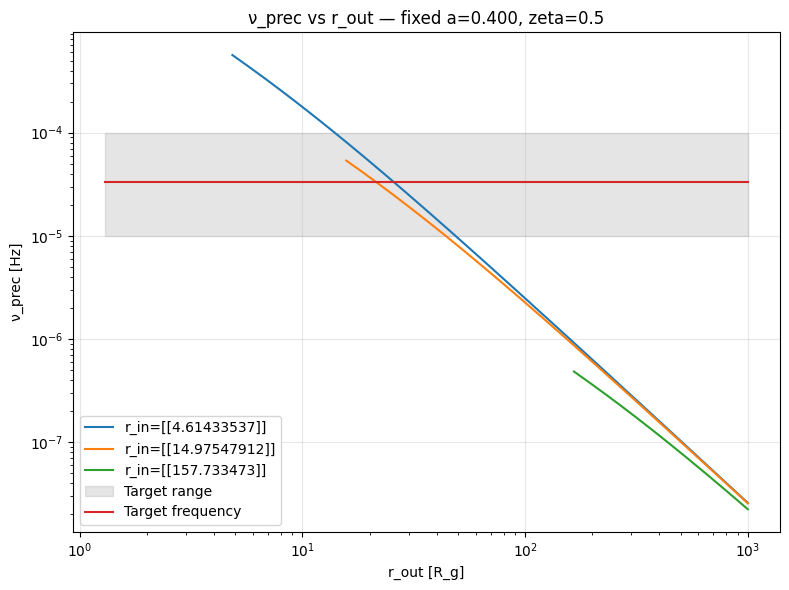

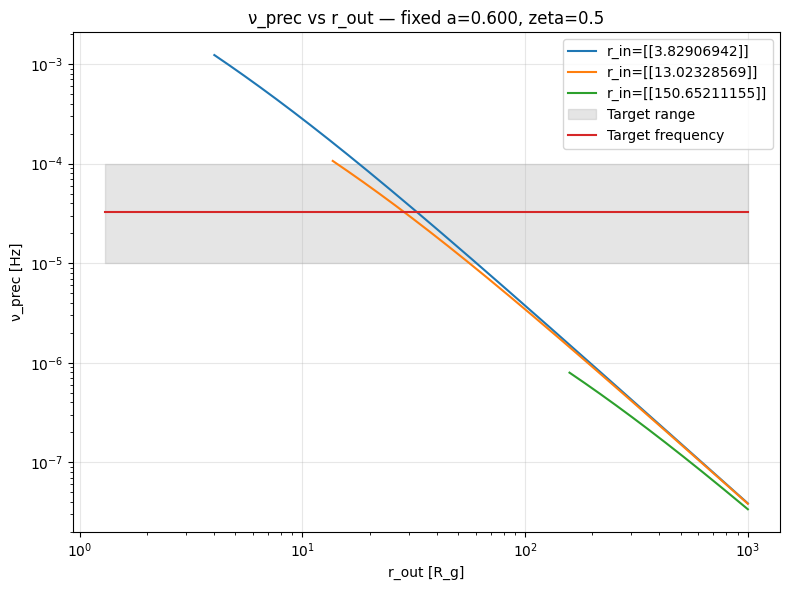

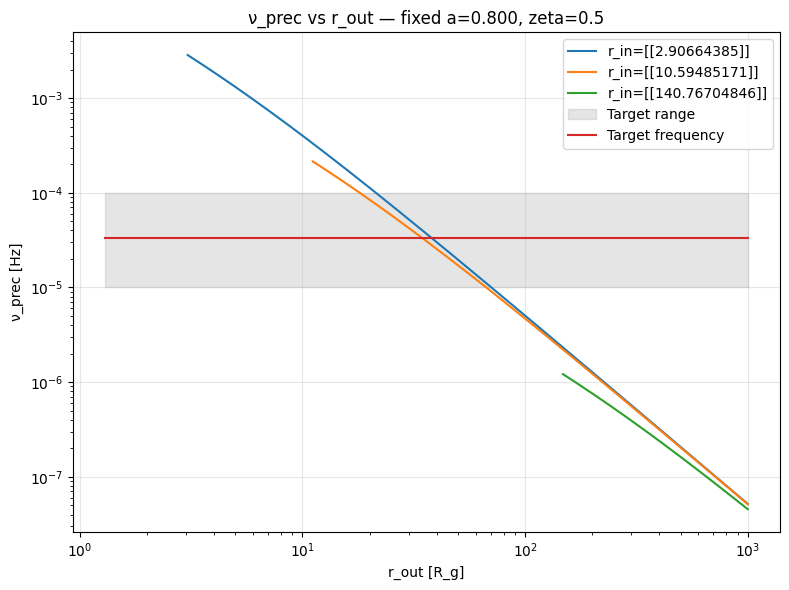

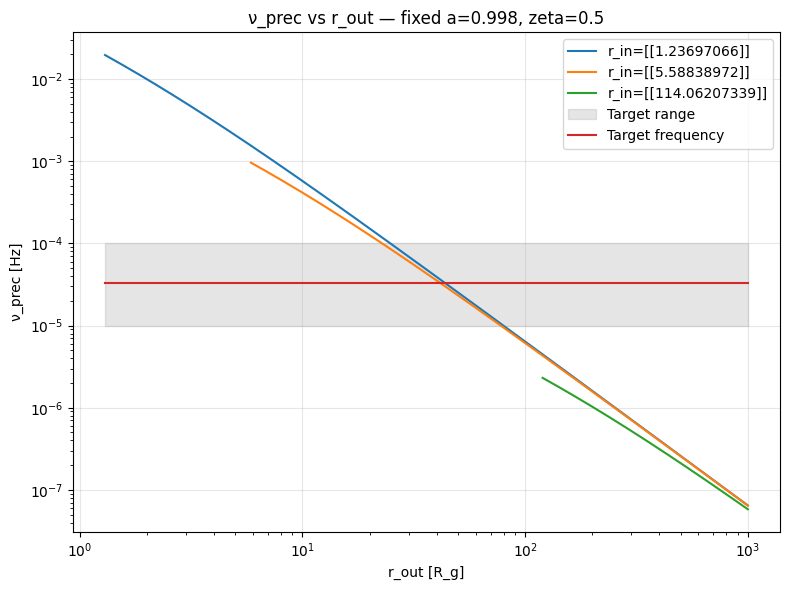

In [60]:
# plots for fixed z, a, different r_in
for iz, zeta in enumerate(zetas):

    for a_val in a_chosen:
        ia = np.where(a_range == a_val)

        plt.figure(figsize=(8, 6))

        for ir in rin_idxs:
            rin_val  = RIN[ia, ir, 0, 0]
            rout_vals = ROUT[ia, ir, :, 0]
            freq_vals = freqs[ia, ir, :, iz]

            mask4 = np.isfinite(freq_vals) & (freq_vals > 0)

            plt.plot(rout_vals[mask4], freq_vals[mask4],
                     label=f"r_in={rin_val}")

        # Target frequency band
        plt.fill_between(r_out_grid[-1, 0], target_min, target_max, color='gray', alpha=0.2,
                        label="Target range")
        plt.plot(r_out_grid[-1, 0], np.ones_like(r_out_grid[-1, 0])*nu0, label="Target frequency")


        plt.title(f"ν_prec vs r_out — fixed a={a_val:.3f}, zeta={zeta}")
        plt.xlabel("r_out [R_g]")
        plt.ylabel("ν_prec [Hz]")
        plt.xscale("log")
        plt.yscale("log")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

###### 3d plots

/tmp/ipykernel_655/2520292207.py:51: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xscale("log")


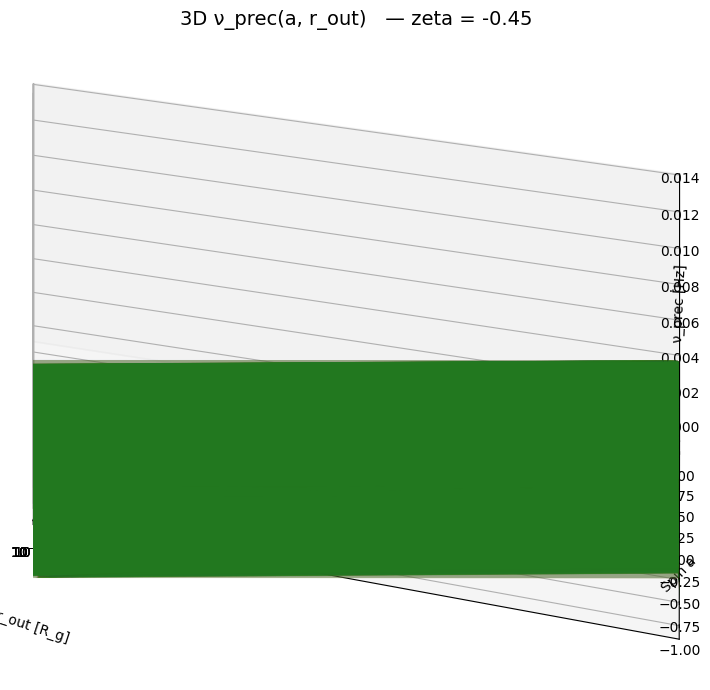

KeyboardInterrupt: 

In [61]:
from mpl_toolkits.mplot3d import Axes3D

rin_indices_to_plot  = [0, 50, 150]                    # example

# Spin indices correspond directly to a_range
Na = len(a_range)
spins = a_range  # vector (Na,)

# ------------------------------
# Main loop: one 3D plot per zeta
# ------------------------------
for iz, zeta in enumerate(zetas):

    fig = plt.figure(figsize=(10, 7))
    ax  = fig.add_subplot(111, projection='3d')

    for ir in rin_indices_to_plot:

        # Extract slices over all spins and all r_out for this (r_in, zeta)
        # Shapes:
        #   ROUT:  (Na, Nr, No, 1)
        #   freqs: (Na, Nr, No, Nz)
        r_out_vals = ROUT[:, ir, :, 0]         # shape (Na, No)
        freq_vals  = freqs[:, ir, :, iz]       # shape (Na, No)

        # Flatten for plotting
        X = r_out_vals.flatten()
        Y = np.repeat(spins, r_out_vals.shape[1])  # spin values
        Z = freq_vals.flatten()

        # Plot surface as scatter (dense surface plots slow)
        ax.plot_trisurf(X, Y, Z, alpha=0.25, linewidth=0.2)

        # ---- Highlight the FOUND POINTS ----
        # mask shape (Na, Nr, No, Nz)
        found_mask = mask[:, ir, :, iz]        # shape (Na, No)

        found_routs = r_out_vals[found_mask]
        found_spins = np.repeat(spins[:, None], r_out_vals.shape[1], axis=1)[found_mask]
        found_freqs = freq_vals[found_mask]

        ax.scatter(
            found_routs, found_spins, found_freqs,
            s=60, color='red', edgecolor='black', label=f"Matches (r_in idx={ir})"
        )

    ax.set_title(f"3D ν_prec(a, r_out)   — zeta = {zeta}", fontsize=14)
    ax.set_xlabel("r_out [R_g]")
    ax.set_ylabel("Spin a")
    ax.set_zlabel("ν_prec [Hz]")
    ax.set_xscale("log")
    ax.set_yscale("linear")

    plt.tight_layout()
    plt.show()


In [ ]:
mask.shape

(1, 1, 500)

#### varying mass